In [1]:
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import gpytorch as gpy

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('whitegrid')

# %matplotlib inline

sns.set_context('notebook', font_scale=1.)
%config InlineBackend.figure_format = "retina"

In [2]:
train_x = t.linspace(0., 1., 100)
train_y = t.sin(2. * np.pi * train_x) + t.randn(train_x.size()) * np.sqrt(0.04)

In [3]:
class ExactGPModel(gpy.models.ExactGP):
    
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        
        self.mean_fn = gpy.means.ConstantMean()
        self.cov_fn = gpy.kernels.ScaleKernel(gpy.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_fn(x)
        cov_x = self.cov_fn(x)
        
        return gpy.distributions.MultivariateNormal(mean_x, cov_x)

In [4]:
likelihood = gpy.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [5]:
train_iter = 50

model.train()
likelihood.train()

optimizer = t.optim.Adam(model.parameters(), lr=0.1)

mll = gpy.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(train_iter):
    
    optimizer.zero_grad()
    
    output = model(train_x)
    
    loss = -mll(output, train_y)
    loss.backward()
    
    print(f'Iter {i + 1}/{train_iter} - Loss: {loss.item():.3f} '  
          f'lengthscale: {model.cov_fn.base_kernel.lengthscale.item()} '
          f'  noise: {model.likelihood.noise.item()}')
    optimizer.step()

Iter 1/50 - Loss: 0.961 lengthscale: 0.6931471824645996   noise: 0.6932471990585327
Iter 2/50 - Loss: 0.930 lengthscale: 0.6443966627120972   noise: 0.6444966793060303
Iter 3/50 - Loss: 0.897 lengthscale: 0.5982527732849121   noise: 0.5982202291488647
Iter 4/50 - Loss: 0.859 lengthscale: 0.5548242330551147   noise: 0.5543739199638367
Iter 5/50 - Loss: 0.815 lengthscale: 0.5140665173530579   noise: 0.5128936171531677
Iter 6/50 - Loss: 0.766 lengthscale: 0.4757188558578491   noise: 0.47370630502700806
Iter 7/50 - Loss: 0.712 lengthscale: 0.43943145871162415   noise: 0.4367428123950958
Iter 8/50 - Loss: 0.656 lengthscale: 0.40499186515808105   noise: 0.4019436836242676
Iter 9/50 - Loss: 0.603 lengthscale: 0.3725096881389618   noise: 0.36925992369651794
Iter 10/50 - Loss: 0.555 lengthscale: 0.34243106842041016   noise: 0.3386496603488922
Iter 11/50 - Loss: 0.513 lengthscale: 0.31533578038215637   noise: 0.31007248163223267
Iter 12/50 - Loss: 0.474 lengthscale: 0.2916520833969116   noise: 0

In [6]:
model.eval()
likelihood.eval()

test_x = t.linspace(-0.5, 1.5, 100)

f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_samp = y_preds.sample(sample_shape=t.Size((10,)))

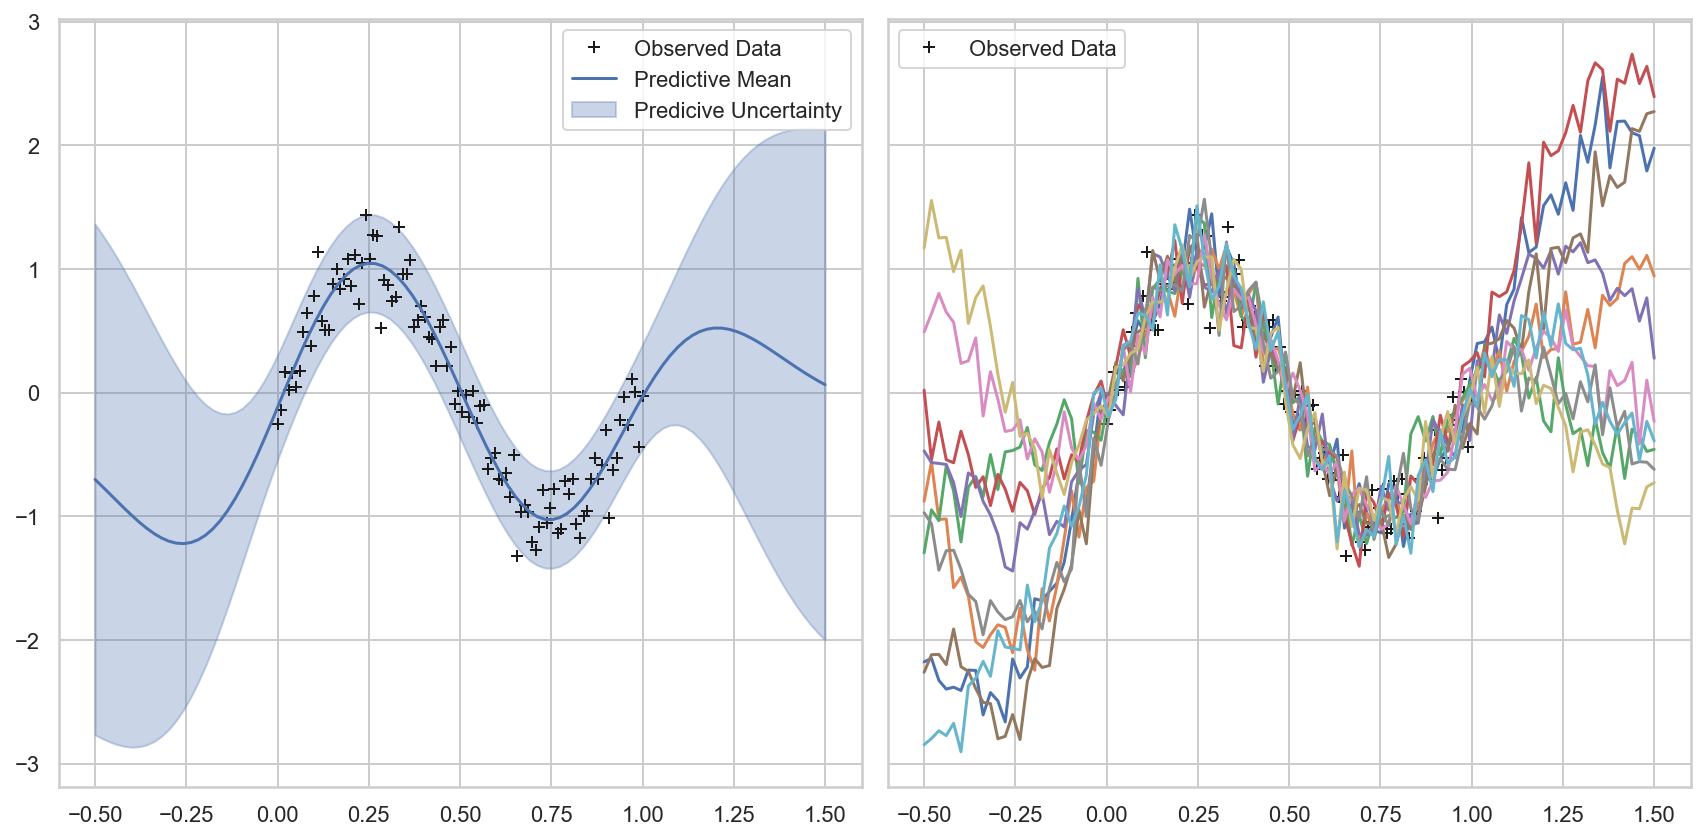

In [7]:
with t.no_grad():
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    lower, upper = y_preds.confidence_region()
    
    axes[0].plot(train_x.numpy(), train_y.numpy(), 'k+', label='Observed Data')
    
    axes[0].plot(test_x.numpy(), f_mean.numpy(), 'b-', label='Predictive Mean')
    
    axes[0].fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.3, color='b', 
                    label='Predicive Uncertainty')
    
    axes[0].legend()
    
    axes[1].plot(train_x.numpy(), train_y.numpy(), 'k+', label='Observed Data')
    axes[1].plot(test_x.numpy(), f_samp.numpy().T)
    axes[1].legend()
    
    fig.tight_layout()

# NN Example

In [8]:
def f(x):
    """
    Target function (noise free).
    """
    return (np.sinc(3 * x) + 0.5 * (x - 0.5)**2).reshape(-1, 1)

In [9]:
# Set seed for reproducibility
np.random.seed(42)

# Generate X's and Y's for training.
x_train = np.array([-0.25, 0, 0.1]).reshape(-1, 1)
y_train = f(x_train)

x_test = np.linspace(-1., 1., 100)
y_test = f(x_test)

x_train = t.tensor(x_train, dtype=t.float32)[:, None]
y_train = t.tensor(y_train, dtype=t.float32)[:, None]

In [10]:
# Train the small BO Net
train_iter = 1000
n_hidden = 50

bo_net = nn.Sequential(nn.Linear(1, n_hidden), 
                       nn.ReLU(), 
                       nn.Linear(n_hidden, n_hidden), 
                       nn.ReLU(), 
                       nn.Linear(n_hidden, 1))
bo_net.train()

optimizer = t.optim.Adam(bo_net.parameters(), lr=1e-3, weight_decay=1e-8)

for i in range(train_iter):
    
    optimizer.zero_grad()
    
    output = bo_net(x_train)
    
    loss = F.mse_loss(output, y_train)
    loss.backward()
    
    if i % 50 == 0:
        print(f'Iter {i + 1}/{train_iter} - Loss: {loss.item():.3f} ')
        
    optimizer.step()

Iter 1/1000 - Loss: 0.928 
Iter 51/1000 - Loss: 0.058 
Iter 101/1000 - Loss: 0.033 
Iter 151/1000 - Loss: 0.016 
Iter 201/1000 - Loss: 0.012 
Iter 251/1000 - Loss: 0.011 
Iter 301/1000 - Loss: 0.010 
Iter 351/1000 - Loss: 0.009 
Iter 401/1000 - Loss: 0.009 
Iter 451/1000 - Loss: 0.008 
Iter 501/1000 - Loss: 0.007 
Iter 551/1000 - Loss: 0.006 
Iter 601/1000 - Loss: 0.005 
Iter 651/1000 - Loss: 0.005 
Iter 701/1000 - Loss: 0.004 
Iter 751/1000 - Loss: 0.003 
Iter 801/1000 - Loss: 0.002 
Iter 851/1000 - Loss: 0.001 
Iter 901/1000 - Loss: 0.001 
Iter 951/1000 - Loss: 0.000 


In [11]:
y_pred = bo_net(t.tensor(x_test, dtype=t.float32)[:, None]).detach().numpy()[:]

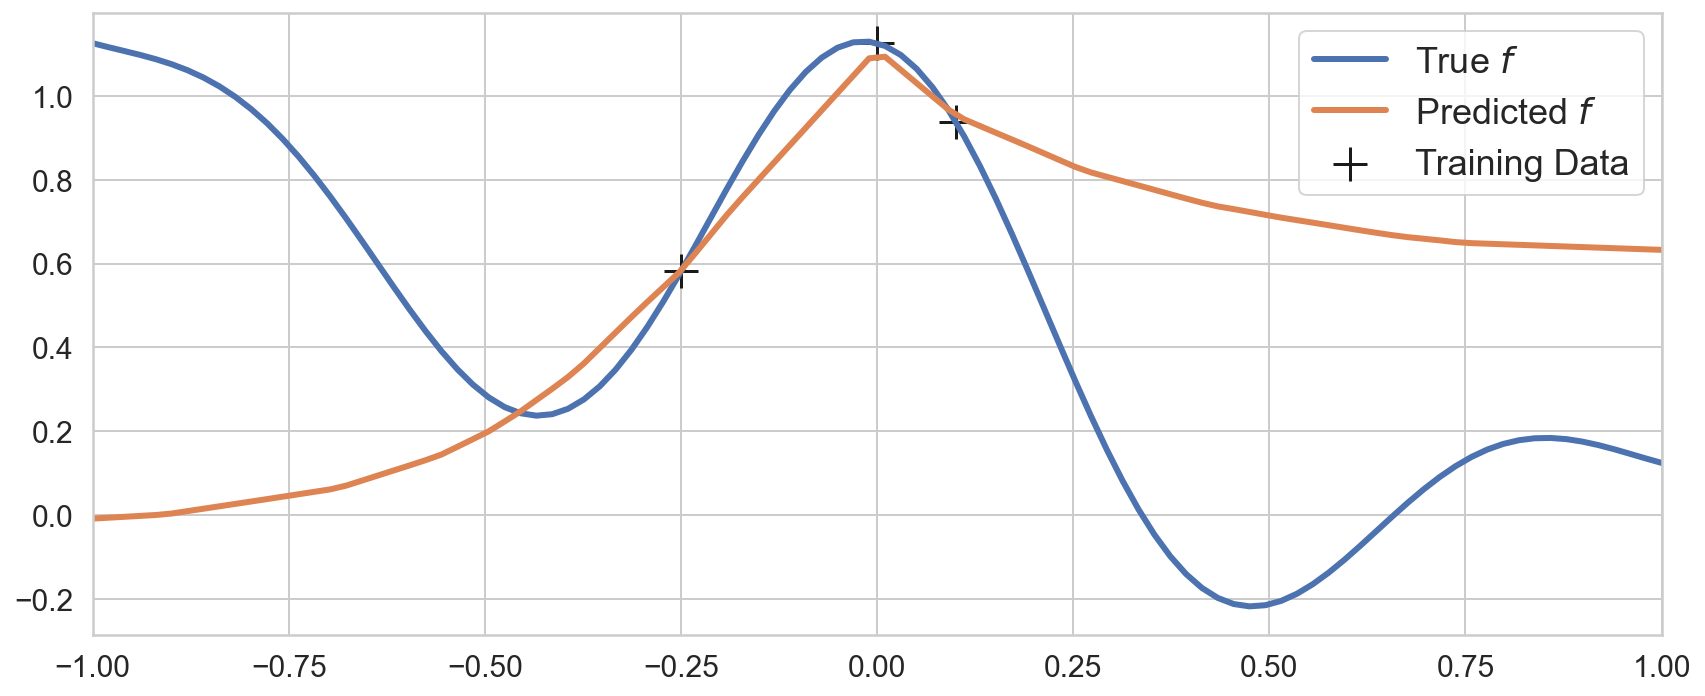

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

ax.scatter(x_train, y_train, label='Training Data', marker='+', c='k', s=300)
ax.plot(x_test, y_test, label='True $f$', lw=3)
ax.plot(x_test, y_pred, label='Predicted $f$', lw=3)

ax.set_xlim([-1, 1])
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.legend(fontsize=18)

fig.tight_layout()
fig.savefig('../img/nn_fit_to_little_data.png')

# GP intro stuff

In [185]:
def f(x):
    return 0.5 * x - .3

lin_train_x = t.linspace(-1., 1., 40)[:, None]
lin_train_2_ind = [5, 31]
lin_train_y = f(lin_train_x) + 0.1 * t.randn(size=lin_train_x.shape)

In [186]:
# Train the small BO Net
train_iter = 5000

lin_model_2 = nn.Linear(1, 1)
lin_model_2.train()

lin_model = nn.Linear(1, 1)
lin_model.train()

lin_opt_2 = t.optim.Adam(lin_model_2.parameters(), lr=1e-3)
lin_opt = t.optim.Adam(lin_model.parameters(), lr=1e-3, weight_decay=1e-8)

for i in range(train_iter):
    
    lin_opt_2.zero_grad()
    lin_opt.zero_grad()
    
    lin_out_2 = lin_model_2(lin_train_x[lin_train_2_ind])
    lin_out = lin_model(lin_train_x)
    
    loss_2 = F.mse_loss(lin_out_2, lin_train_y[lin_train_2_ind])
    loss = F.mse_loss(lin_out, lin_train_y)
    
    loss_2.backward()
    loss.backward()
    
    if i % 500 == 0:
        print(f'Iter {i + 1}/{train_iter} - Loss 2: {loss_2.item():.3f} Loss: {loss.item():.3f} ')
        
    lin_opt_2.step()
    lin_opt.step()

Iter 1/5000 - Loss 2: 0.496 Loss: 0.708 
Iter 501/5000 - Loss 2: 0.049 Loss: 0.279 
Iter 1001/5000 - Loss 2: 0.002 Loss: 0.102 
Iter 1501/5000 - Loss 2: 0.000 Loss: 0.031 
Iter 2001/5000 - Loss 2: 0.000 Loss: 0.010 
Iter 2501/5000 - Loss 2: 0.000 Loss: 0.006 
Iter 3001/5000 - Loss 2: 0.000 Loss: 0.005 
Iter 3501/5000 - Loss 2: 0.000 Loss: 0.005 
Iter 4001/5000 - Loss 2: 0.000 Loss: 0.005 
Iter 4501/5000 - Loss 2: 0.000 Loss: 0.005 


In [187]:
lin_2_pred = lin_model_2(lin_train_x)
lin_pred = lin_model(lin_train_x)

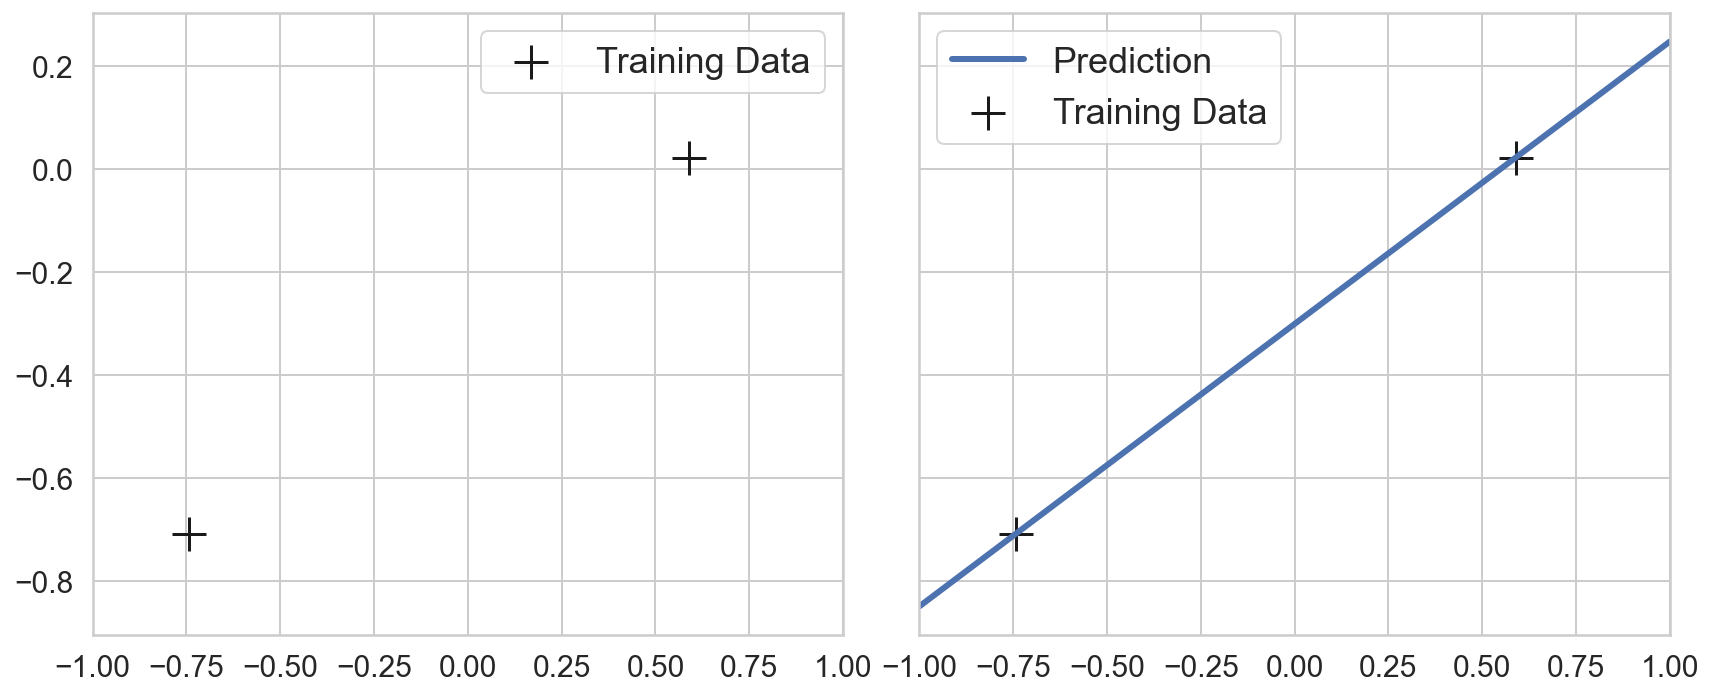

In [188]:
with t.no_grad():
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)

    axes[0].scatter(lin_train_x[lin_train_2_ind],
                    lin_train_y[lin_train_2_ind],
                    label='Training Data', marker='+', c='k', s=300)
    
    axes[1].scatter(lin_train_x[lin_train_2_ind],
                    lin_train_y[lin_train_2_ind],
                    label='Training Data', marker='+', c='k', s=300)
    axes[1].plot(lin_train_x.numpy()[:], lin_2_pred.numpy()[:], lw=3, label="Prediction")

    for i in range(2):
        axes[i].set_xlim([-1, 1])
        axes[i].tick_params(axis='both', which='major', labelsize=15)
        axes[i].tick_params(axis='both', which='minor', labelsize=8)
        axes[i].legend(fontsize=18)

    fig.tight_layout()
    fig.savefig('../img/two_point_lin_fit.png')

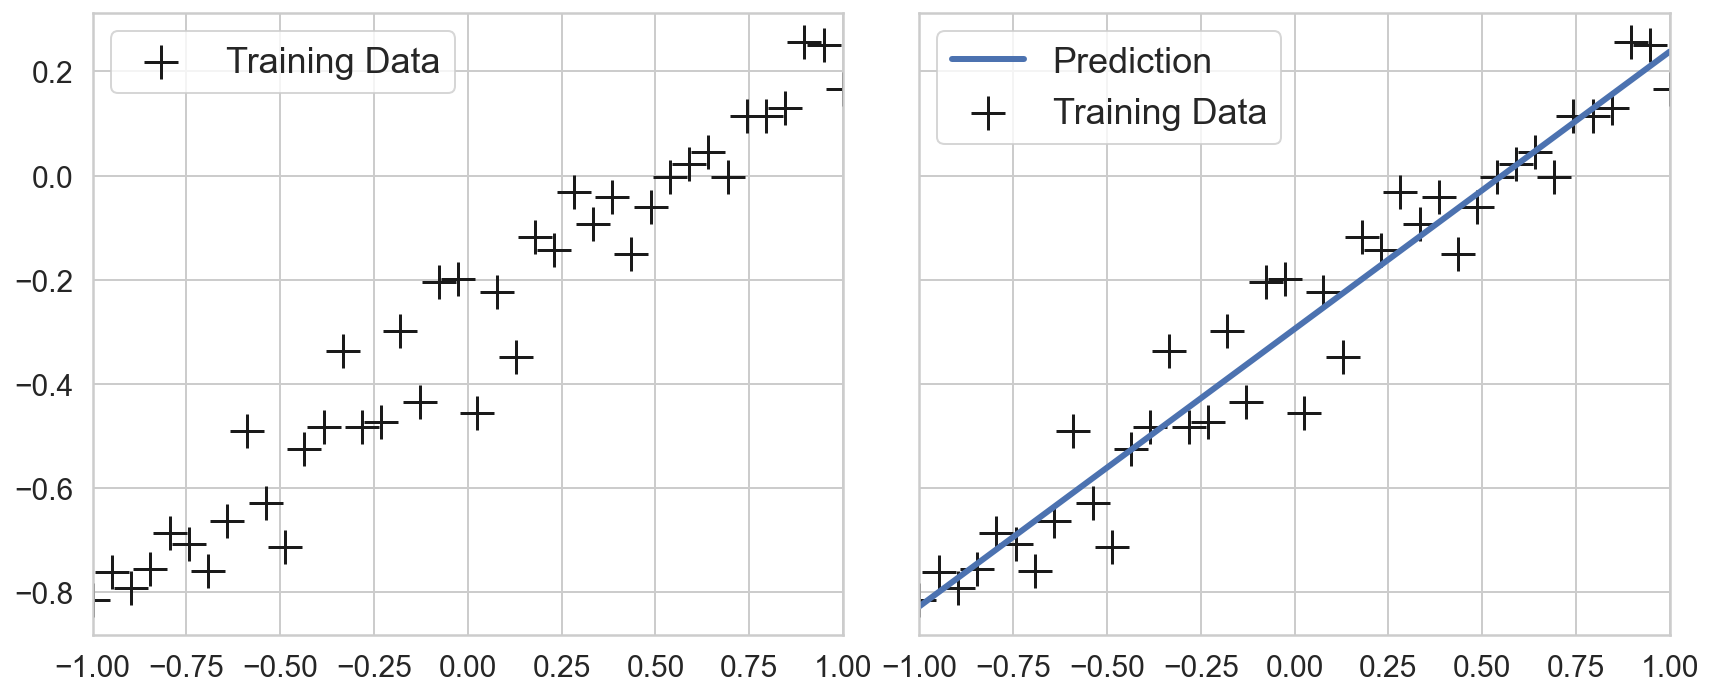

In [189]:
with t.no_grad():
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)

    axes[0].scatter(lin_train_x,
                    lin_train_y,
                    label='Training Data', marker='+', c='k', s=300)
    
    axes[1].scatter(lin_train_x,
                    lin_train_y,
                    label='Training Data', marker='+', c='k', s=300)
    axes[1].plot(lin_train_x.numpy()[:], lin_pred.numpy()[:], lw=3, label="Prediction")

    for i in range(2):
        axes[i].set_xlim([-1, 1])
        axes[i].tick_params(axis='both', which='major', labelsize=15)
        axes[i].tick_params(axis='both', which='minor', labelsize=8)
        axes[i].legend(fontsize=18)

    fig.tight_layout()
    fig.savefig('../img/lin_fit.png')

## Bayesian Lin Reg

In [190]:
lin_train_1_ind = [5]

In [220]:
class BayesLinReg(gpy.models.ExactGP):
    
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        
        self.mean_fn = gpy.means.ConstantMean(prior=gpy.priors.NormalPrior(0., 1.))
        self.cov_fn = gpy.kernels.ScaleKernel(
            gpy.kernels.LinearKernel(variance_prior=gpy.priors.NormalPrior(0., 1.)))
        
    def forward(self, x):
        mean_x = self.mean_fn(x)
        cov_x = self.cov_fn(x)
        
        return gpy.distributions.MultivariateNormal(mean_x, cov_x)

In [221]:
lin_likelihood = gpy.likelihoods.GaussianLikelihood()
bayes_lin_model = BayesLinReg(lin_train_x[lin_train_1_ind], lin_train_y[lin_train_1_ind], lin_likelihood)

prior_cov = bayes_lin_model.cov_fn(lin_train_x)
prior_mean = bayes_lin_model.mean_fn(lin_train_x)

prior_dist = gpy.distributions.MultivariateNormal(prior_mean, prior_cov)

prior_lower, prior_upper = prior_dist.confidence_region()
prior_samps = prior_dist.sample(t.Size((30,)))

/Users/gergelyflamich/Documents/PhD/presentations/tmx-bayesopt-talk/venv/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


No handles with labels found to put in legend.


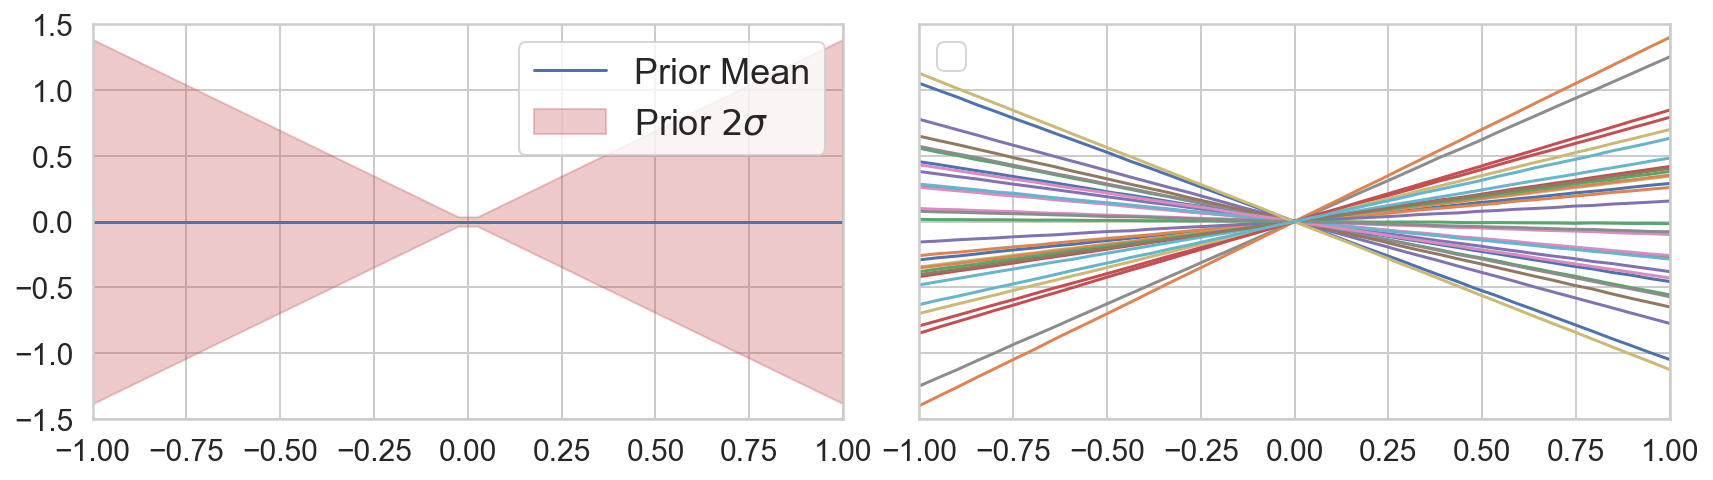

In [222]:
with t.no_grad():
    fig, axes = plt.subplots(1, 2, figsize=(12, 3.5), sharey=True, sharex=True)

    axes[0].plot(lin_train_x.numpy()[:], prior_mean.numpy()[:], label='Prior Mean')
    axes[0].fill_between(lin_train_x.numpy()[:, 0], 
                         prior_lower.numpy()[:], 
                         prior_upper.numpy()[:], 
                         alpha=0.3,
                         color='r',
                         label='Prior $2\sigma$')
    axes[0].legend()
    
    axes[1].plot(lin_train_x.numpy()[:], prior_samps.numpy().T)
    
    for i in range(2):
        axes[i].set_xlim([-1, 1])
        axes[i].tick_params(axis='both', which='major', labelsize=15)
        axes[i].tick_params(axis='both', which='minor', labelsize=8)
        axes[i].legend(fontsize=18)
        axes[i].set_ylim([-1.5, 1.5])

    fig.tight_layout()
    fig.savefig('../img/bayes_lin_prior.png')

In [223]:
bayes_lin_model.eval()

post_dist = bayes_lin_model(lin_train_x)
post_mean = post_dist.mean
post_lower, post_upper = post_dist.confidence_region()
post_samps = post_dist.sample(t.Size((30,)))

/Users/gergelyflamich/Documents/PhD/presentations/tmx-bayesopt-talk/venv/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


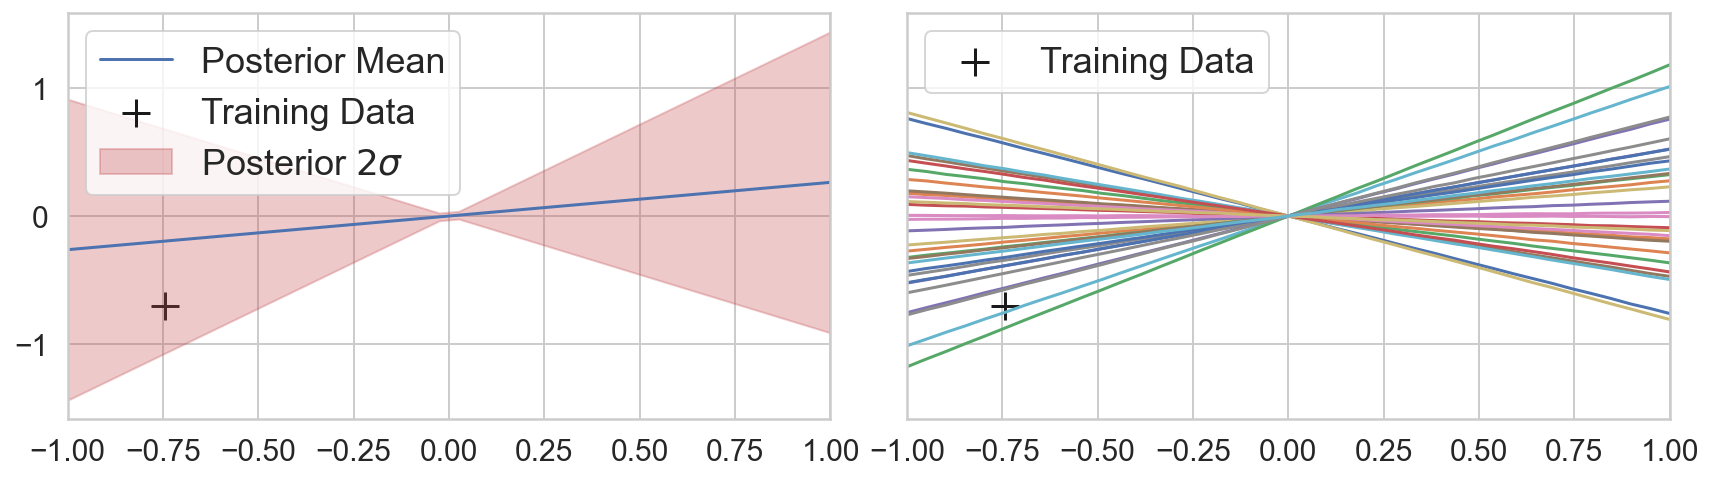

In [224]:
with t.no_grad():
    fig, axes = plt.subplots(1, 2, figsize=(12, 3.5), sharey=True, sharex=True)
    
    axes[0].scatter(lin_train_x[lin_train_1_ind].numpy()[:], 
                    lin_train_y[lin_train_1_ind].numpy()[:], 
                    c='k', marker='+', s=200, label='Training Data')
    axes[0].plot(lin_train_x.numpy()[:], post_mean.numpy()[:], label='Posterior Mean')
    axes[0].fill_between(lin_train_x.numpy()[:, 0], 
                         post_lower.numpy()[:], 
                         post_upper.numpy()[:], 
                         alpha=0.3,
                         color='r',
                         label='Posterior $2\sigma$')
    axes[0].legend()
    
    axes[1].scatter(lin_train_x[lin_train_1_ind].numpy()[:], 
                    lin_train_y[lin_train_1_ind].numpy()[:], 
                    c='k', marker='+', s=200, label='Training Data')
    axes[1].plot(lin_train_x.numpy()[:], post_samps.numpy().T)
    
    for i in range(2):
        axes[i].set_xlim([-1, 1])
        axes[i].tick_params(axis='both', which='major', labelsize=15)
        axes[i].tick_params(axis='both', which='minor', labelsize=8)
        axes[i].legend(fontsize=18)

    fig.tight_layout()
    fig.savefig('../img/bayes_lin_post.png')

## Other kernels

### RBF

In [211]:
mean_fn = gpy.means.ConstantMean()
cov_fn = gpy.kernels.ScaleKernel(gpy.kernels.RBFKernel())

prior_cov = cov_fn(lin_train_x)
prior_mean = mean_fn(lin_train_x)

prior_dist = gpy.distributions.MultivariateNormal(prior_mean, prior_cov)

prior_lower, prior_upper = prior_dist.confidence_region()
prior_samps = prior_dist.sample(t.Size((20,)))

/Users/gergelyflamich/Documents/PhD/presentations/tmx-bayesopt-talk/venv/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


No handles with labels found to put in legend.


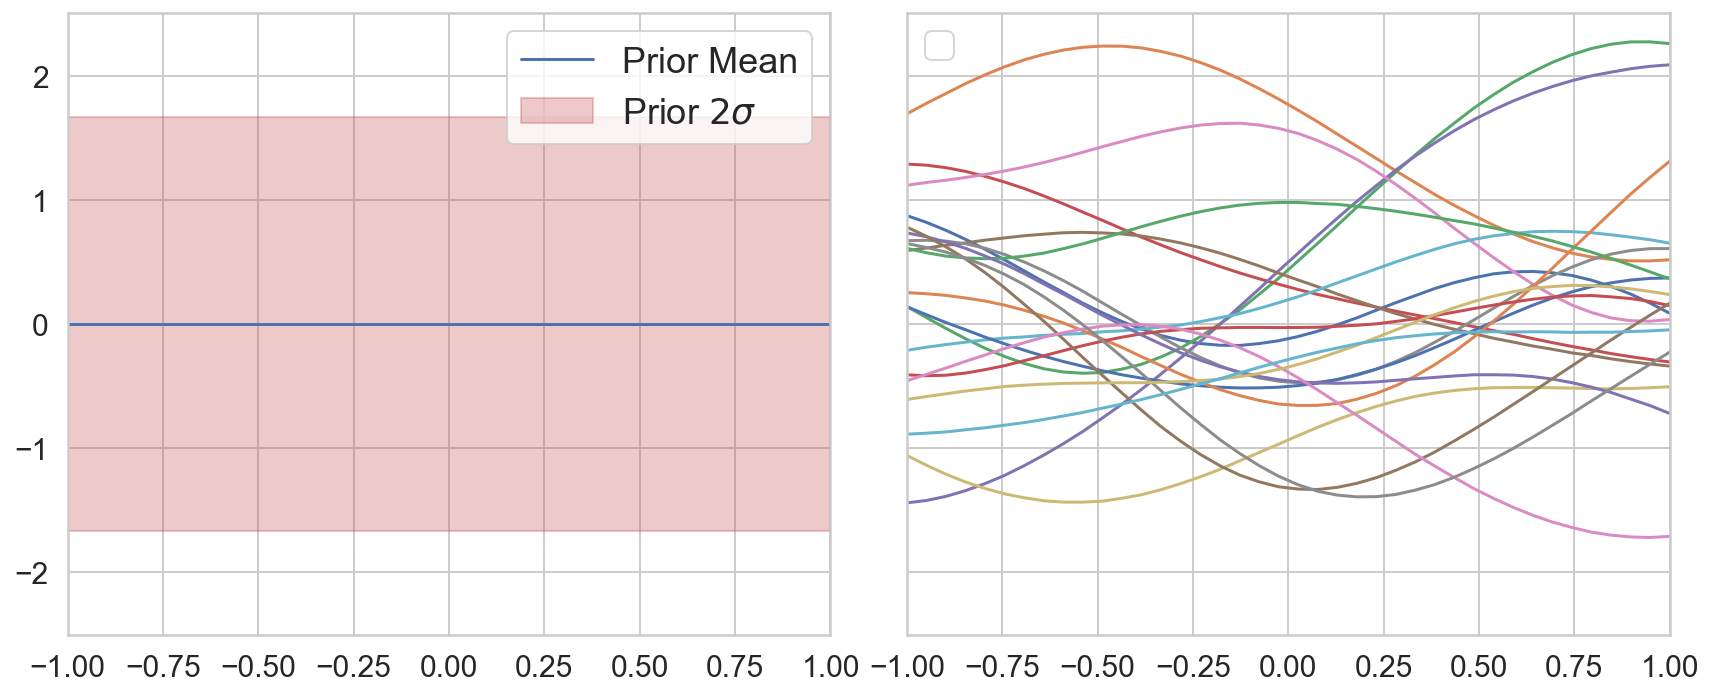

In [212]:
with t.no_grad():
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)

    axes[0].plot(lin_train_x.numpy()[:], prior_mean.numpy()[:], label='Prior Mean')
    axes[0].fill_between(lin_train_x.numpy()[:, 0], 
                         prior_lower.numpy()[:], 
                         prior_upper.numpy()[:], 
                         alpha=0.3,
                         color='r',
                         label='Prior $2\sigma$')
    
    axes[1].plot(lin_train_x.numpy()[:], prior_samps.numpy().T)
    
    for i in range(2):
        axes[i].set_xlim([-1, 1])
        axes[i].tick_params(axis='both', which='major', labelsize=15)
        axes[i].tick_params(axis='both', which='minor', labelsize=8)
        axes[i].legend(fontsize=18)
        axes[i].set_ylim([-2.5, 2.5])

    fig.tight_layout()
    fig.savefig('../img/rbf_prior.png')

### Periodic

In [214]:
mean_fn = gpy.means.ConstantMean()
cov_fn = gpy.kernels.ScaleKernel(gpy.kernels.PeriodicKernel())

prior_cov = cov_fn(lin_train_x)
prior_mean = mean_fn(lin_train_x)

prior_dist = gpy.distributions.MultivariateNormal(prior_mean, prior_cov)

prior_lower, prior_upper = prior_dist.confidence_region()
prior_samps = prior_dist.sample(t.Size((5,)))

/Users/gergelyflamich/Documents/PhD/presentations/tmx-bayesopt-talk/venv/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


No handles with labels found to put in legend.


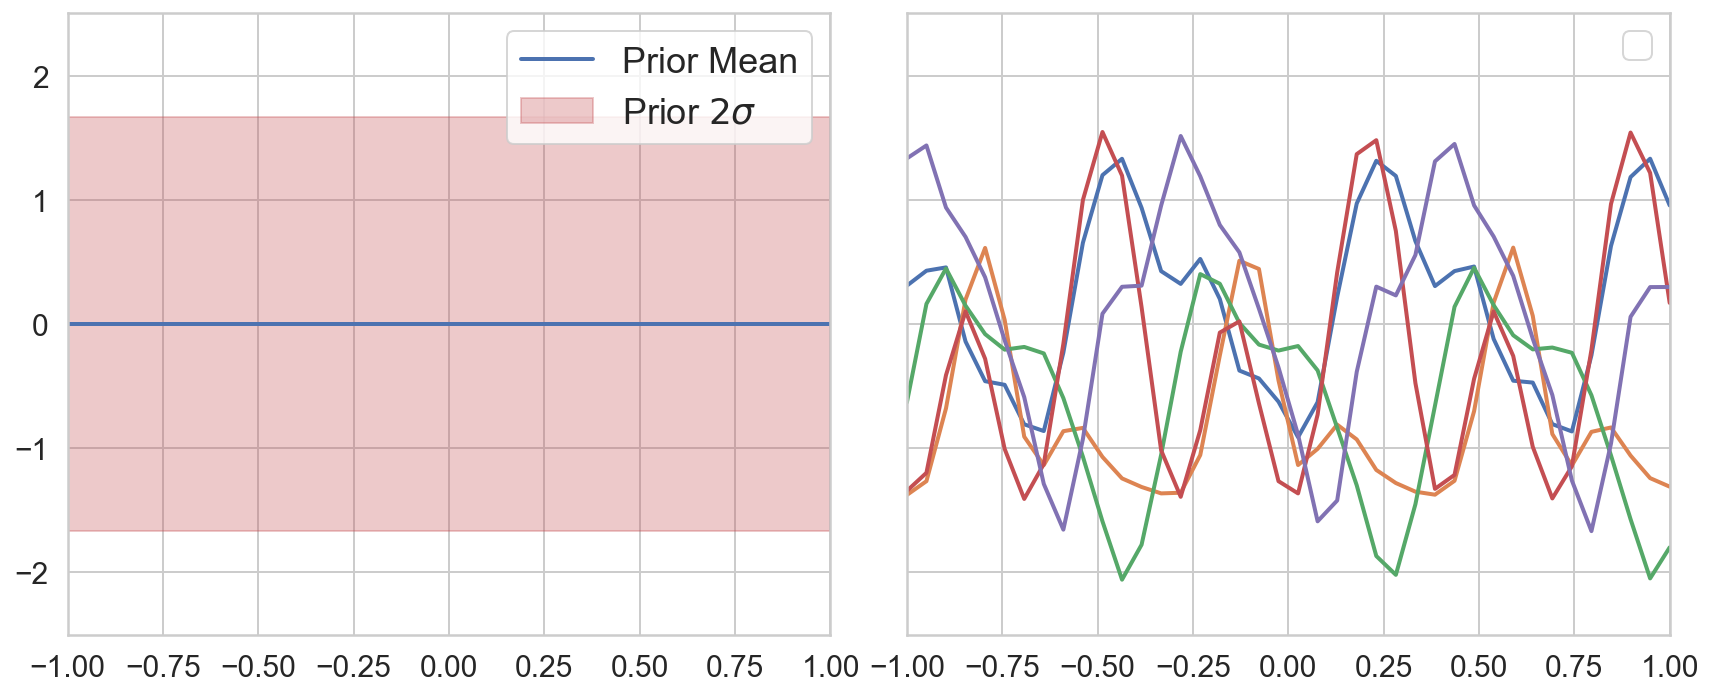

In [219]:
with t.no_grad():
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)

    axes[0].plot(lin_train_x.numpy()[:], prior_mean.numpy()[:], label='Prior Mean', lw=2)
    axes[0].fill_between(lin_train_x.numpy()[:, 0], 
                         prior_lower.numpy()[:], 
                         prior_upper.numpy()[:], 
                         alpha=0.3,
                         color='r',
                         label='Prior $2\sigma$')
    
    axes[1].plot(lin_train_x.numpy()[:], prior_samps.numpy().T, lw=2)
    
    for i in range(2):
        axes[i].set_xlim([-1, 1])
        axes[i].tick_params(axis='both', which='major', labelsize=15)
        axes[i].tick_params(axis='both', which='minor', labelsize=8)
        axes[i].legend(fontsize=18)
        axes[i].set_ylim([-2.5, 2.5])

    fig.tight_layout()
    fig.savefig('../img/periodic_prior.png')